# Start From Here

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#!rm -r -d "/content/drive/My Drive/GP/dstl/4_bands_10_classes_5000_Patches/data"
!rm -r -d msk
!rm -r -d subm
!rm -r -d weights

rm: cannot remove 'msk': No such file or directory
rm: cannot remove 'subm': No such file or directory
rm: cannot remove 'weights': No such file or directory


In [ ]:
!mkdir -p msk subm weights

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow
import pandas as pd
import numpy as np
from shapely.wkt import loads           # https://pypi.org/project/Shapely/
from matplotlib.patches import Polygon, Patch  # plot Polygon using Matplotlib:https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.patches.Polygon.html
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_similarity_score
from collections import defaultdict
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import os
import shutil
import glob
import re
import zipfile
!pip install tifffile
import tifffile as tiff
import cv2
import random
from keras.models import Model, load_model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
#K.set_image_dim_ordering('th')
K.set_image_data_format('channels_first')
import warnings
warnings.filterwarnings("default", category=DeprecationWarning)

In [3]:
bands_choices = [3,4,20]
patches_choices = [2500, 5000]
case_choices = ["esri", ""]
path_choices = [f"/content/drive/My Drive/GP/dstl/{chosen_bands}_bands_10_classes_{chosen_patches}_Patches/", 
                f"/content/drive/My Drive/GP/dstl/trial/{chosen_bands}_bands_10_classes_{chosen_patches}_Patches/"
                ]

chosen_bands = bands_choices[1]
chosen_patches = patches_choices[1]
chosen_case = case_choices[0]
chosen_path = path_choices[1]

NameError: ignored

In [ ]:
if chosen_path == path_choices[1]:
  if os.path.exists(chosen_path) and os.path.isdir(chosen_path):
    shutil.rmtree(chosen_path)
    !mkdir -p msk subm weights

NameError: ignored

In [20]:
tr_wkt = pd.read_csv('/content/drive/My Drive/GP/dstl/train_wkt_v4.csv')  # Well-known text Multipolygon
grid_sizes = pd.read_csv('/content/drive/My Drive/GP/dstl/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
chosen_bands=None
chosen_case=None
def convert_coordinates(coords, img_size, xy_coords):
    '''
    Convert all image coordinates given range
    '''
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymin = xy_coords              # Xmax - maximum X coordinate for the image
                                        # Ymin - minimum Y coordinate for the image
    Height, Weight = img_size            # image sizes
    W = 1.0 * Weight * Weight / (Weight + 1)
    H = 1.0 * Height * Height / (Height + 1)
    xf = W / Xmax
    yf = H / Ymin
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int
def get_xmax_ymin(GS, imageId):
    '''
    Find maximum coordinates for x and minimun coordinates for y
    ''' 
    xmax, ymin = GS[GS.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)
def get_polygon_list(wkt_list, imageId, cType):
    '''
    Find polygon list for all images with there class label
    '''
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list[wkt_list.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = loads(multipoly_def.values[0])
    return polygonList
def get_and_convert_contours(polygonList, img_size, xy_coods):
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    if img_size is None:
       return None
    if img_size[0]<=0 or img_size[1]<=0:
      return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = convert_coordinates(perim, img_size, xy_coods)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = convert_coordinates(interior, img_size, xy_coods)
            interior_list.append(interior_c)
    return perim_list, interior_list
def plot_mask_from_contours(img_size, contours):
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    if img_size is None:
       return None
    if img_size[0]<=0 or img_size[1]<=0:
      return None
    img_mask = np.zeros(img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list,1)    
    cv2.fillPoly(img_mask, interior_list,0)
    return img_mask
def generate_mask_for_image_and_class(img_size, imageId, class_type, GS=grid_sizes, wkt_list=tr_wkt):
    '''
    Fill polygons exterior and interior points and return mask of images
    '''
    xy_coods = get_xmax_ymin(GS, imageId)
    polygon_list = get_polygon_list(wkt_list, imageId, class_type)
    contours = get_and_convert_contours(polygon_list, img_size, xy_coods)
    mask = plot_mask_from_contours(img_size, contours)
    return mask
def all_image(image_id, dims=chosen_bands, size=800, case=chosen_case):
    if size == None or image_id==None:
       return None
    if size<=0:
      return None
    if dims == 3:
      if case == "esri":
          dir = "/content/drive/My Drive/GP/Raster/"
          pattern = r'*.tif'
          gen = glob.iglob(os.path.join(dir, pattern))
          filename = next(gen)
          try:
            img_4 = tiff.imread(filename)
          except:
            print("can't read image")
            return None 
          img = np.zeros((3000, 3000, dims), "float32")
          img = img_4[ 1500:2500 , 5000:6000 , 0:3]
          #img = np.rollaxis(img, 0, 3)
          img = cv2.resize(img, (size, size))
      else:
          filename = "/content/drive/My Drive/GP/dstl/three_band/{}.tif".format(image_id)
          try:
            img = tiff.imread(filename)
          except:
            print("can't read image")
            return None 
          img = np.rollaxis(img, 0, 3)
          img = cv2.resize(img, (size, size))
    
    elif dims == 4:
        if case == 'esri':
          dir = "/content/drive/My Drive/GP/Raster/"
          pattern = r'*.tif'
          gen = glob.iglob(os.path.join(dir, pattern))
          filename = next(gen)
          try:
            img = tiff.imread(filename)
          except:
            print("can't read image")
            return None 
          #img = cv2.resize(img, (size, size))
        else:
          # for type M 
          img_M = np.transpose(tiff.imread("/content/drive/My Drive/GP/dstl/sixteen_band/{}_M.tif".format(image_id)), (1,2,0))
          img_M = cv2.resize(img_M, (size, size))

          # for RGB 
          img_RGB = tiff.imread("/content/drive/My Drive/GP/dstl/three_band/{}.tif".format(image_id))
          img_RGB = np.rollaxis(img_RGB, 0, 3)
          img_RGB = cv2.resize(img_RGB, (size, size))
          
          img = np.zeros((img_RGB.shape[0], img_RGB.shape[1], dims), "float32")
          #print(f'RGB shape: {img_RGB.shape}\nM shape: {img_M.shape}\nimg shape: {img.shape}')
          img[..., 0:3] = img_RGB
          img[..., 3] = img_M[ : , : , 7]

    elif dims==8:
        filename = "/content/drive/My Drive/GP/dstl/sixteen_band/{}_M.tif".format(image_id)
        try:
            img = tiff.imread(filename)
        except:
            print("can't read image")
            return None 
        img = np.rollaxis(img, 0, 3)
        img = cv2.resize(img, (size, size))
        
    elif dims==20:
        # for type M 
        img_M = np.transpose(tiff.imread("/content/drive/My Drive/GP/dstl/sixteen_band/{}_M.tif".format(image_id)), (1,2,0))
        img_M = cv2.resize(img_M, (size, size))
        # for type A
        img_A = np.transpose(tiff.imread("/content/drive/My Drive/GP/dstl/sixteen_band/{}_A.tif".format(image_id)), (1,2,0))
        img_A = cv2.resize(img_A, (size, size))
        # for type P
        img_P = tiff.imread("/content/drive/My Drive/GP/dstl/sixteen_band/{}_P.tif".format(image_id))
        img_P = cv2.resize(img_P, (size, size))

        filename = "/content/drive/My Drive/GP/dstl/three_band/{}.tif".format(image_id)
        # for RGB 
        try:
            img_RGB = tiff.imread(filename)
        except:
            print("can't read image")
            return None 
        img_RGB = np.rollaxis(img_RGB, 0, 3)
        img_RGB = cv2.resize(img_RGB, (size, size))

        img = np.zeros((img_RGB.shape[0], img_RGB.shape[1], dims), "float32")
        img[..., 0:3] = img_RGB
        img[..., 3] = img_P
        img[..., 4:12] = img_M
        img[..., 12:21] = img_A

    return img

In [4]:
def stretch_n(img, lower_percent=5, higher_percent=95):    # https://www.kaggle.com/aamaia/rgb-using-m-bands-example
    out = np.zeros_like(img, dtype=np.float32)
    n = img.shape[2]
    for i in range(n):
        a = 0       # np.min(img)
        b = 1       # np.max(img)
        c = np.percentile(img[:, :, i], lower_percent)
        d = np.percentile(img[:, :, i], higher_percent)
        t = a + (img[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t
    return out.astype(np.float32)
smooth = 1e-12
def jaccard_coef(y_true, y_pred):
    # # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def jaccard_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

In [5]:
N_Cls = 10 # total number of class
def stick_all_train():
    print("let's stick all imgs together")
    s = 800 # 800 is the size of the all images
  
    x = np.zeros((5 * s, 5 * s, chosen_bands))        # the array has the dimensions of 5 images wide and 5 images high. 20 Channels
    y = np.zeros((5 * s, 5 * s, N_Cls))

    ids = sorted(tr_wkt.ImageId.unique())
    print(len(ids))
    for i in range(5):
        for j in range(5):
            id = ids[5 * i + j]
            img = all_image(id)
            img = stretch_n(img)
            print(img.shape, id, np.amax(img), np.amin(img))
            x[s * i:s * i + s, s * j:s * j + s, :] = img[:s, :s, :]
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class((img.shape[0], img.shape[1]), id, z + 1)[:s, :s]

    print(np.amax(y), np.amin(y))

    np.save((chosen_path+'data/x_trn_%d') % N_Cls, x)
    np.save((chosen_path+'data/y_trn_%d') % N_Cls, y)


def get_patches(img, msk, amt=chosen_patches, aug=True):
    is2 = int(1.0 * ISZ)
    xm, ym = img.shape[0] - is2, img.shape[1] - is2

    x, y = [], []

    tr = [0.4, 0.1, 0.1, 0.15, 0.3, 0.95, 0.1, 0.05, 0.001, 0.005]      # threshold for all class which is the best for pixels
    for i in range(amt):
        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        im = img[xc:xc + is2, yc:yc + is2]        # generate random image
        ms = msk[xc:xc + is2, yc:yc + is2]        # generate random mask 

        for j in range(N_Cls):
            sm = np.sum(ms[:, :, j])
            if 1.0 * sm / is2 ** 2 > tr[j]:
                if aug:
                    if random.uniform(0, 1) > 0.5:
                        im = im[::-1]
                        ms = ms[::-1]
                    if random.uniform(0, 1) > 0.5:
                        im = im[:, ::-1]
                        ms = ms[:, ::-1]

                x.append(im)
                y.append(ms)

    x, y = 2 * np.transpose(x, (0, 3, 1, 2)) - 1, np.transpose(y, (0, 3, 1, 2))
    print(x.shape, y.shape, np.amax(x), np.amin(x), np.amax(y), np.amin(y))
    return x, y

NameError: ignored

## Split train and validation data

In [ ]:
def make_val():
    print("let's pick some samples for validation")
    img = np.load((chosen_path+'data/x_trn_%d.npy') % N_Cls)
    msk = np.load((chosen_path+'data/y_trn_%d.npy') % N_Cls)
    x, y = get_patches(img, msk, amt=1500)

    np.save((chosen_path+'data/x_tmp_%d') % N_Cls, x)
    np.save((chosen_path+'data/y_tmp_%d') % N_Cls, y)

In [ ]:
ISZ = 160
def get_unet():
    inputs = Input((chosen_bands, ISZ, ISZ))
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding ='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding ='same')(conv5)
    
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=1)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=1)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=1)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(N_Cls, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    return model

In [ ]:
model = get_unet()

if os.path.isfile(f"{chosen_path}unet_{chosen_bands}_10_jk_BestScore"):
  model.load_weights(f"{chosen_path}unet_{chosen_bands}_10_jk_BestScore")
  print("weights loaded ......")
#model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


weights loaded ......


In [ ]:
import keras
import pydot
from keras.utils import plot_model
import pydotplus
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png');

In [ ]:
def calc_jacc(model):
    img = np.load((chosen_path+'data/x_tmp_%d.npy') % N_Cls)
    msk = np.load((chosen_path+'data/y_tmp_%d.npy') % N_Cls)

    prd = model.predict(img, batch_size=4)
    print(prd.shape, msk.shape)
    avg, trs = [], []

    for i in range(N_Cls):
        t_msk = msk[:, i, :, :]
        t_prd = prd[:, i, :, :]
        t_msk = t_msk.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])
        t_prd = t_prd.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])

        m, b_tr = 0, 0
        for j in range(10):
            tr = j / 10.0
            pred_binary_mask = t_prd > tr

            jk = jaccard_similarity_score(t_msk, pred_binary_mask)      # calculate jaccard similarity for predict mask and actual mask
            if jk > m:
                m = jk
                b_tr = tr
        print(i, m, b_tr)
        avg.append(m)
        trs.append(b_tr)

    score = sum(avg) / 10.0
    return score, trs

In [ ]:
def train_net():
    print("start train net")
    x_val, y_val = np.load((chosen_path+'data/x_tmp_%d.npy') % N_Cls), np.load((chosen_path+'data/y_tmp_%d.npy') % N_Cls)    # load validate data
    img = np.load((chosen_path+'data/x_trn_%d.npy') % N_Cls)
    msk = np.load((chosen_path+'data/y_trn_%d.npy') % N_Cls)
  
    model_checkpoint = ModelCheckpoint('weights/unet_tmp.hdf5', monitor='loss', save_best_only=True)   # moniter loss function
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir='./logs')          #tensorflow histogram for ploting
    arr = []
    for i in range(2):
        x_trn, y_trn = get_patches(img, msk)  # generate train data
        model.fit(x_trn, y_trn, batch_size=64, nb_epoch=5, verbose=1, shuffle=True,
                  callbacks=[model_checkpoint,tensorboard_callback], validation_data=(x_val, y_val))       # fit model
        del x_trn
        del y_trn
        score, trs = calc_jacc(model)
        print('val jk', score)
        arr.append(float("{:.4f}".format(score)))
        model.save_weights((f'{chosen_path}unet_{chosen_bands}_10_jk%.4f') % score)       #save weights 
    arr.sort()
    os.rename(f'{chosen_path}unet_{chosen_bands}_10_jk{arr[-1]}', f'{chosen_path}unet_{chosen_bands}_10_jk_BestScore')
    return model

In [ ]:
if chosen_path == path_choices[1]:
  stick_all_train()

In [ ]:
if chosen_path == path_choices[1]:
  make_val()

In [ ]:
if chosen_path == path_choices[1]:
  model = train_net()

In [ ]:
# call calc_jacc for calculate score
score, trs = calc_jacc(model)

(516, 10, 160, 160) (516, 10, 160, 160)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0 0.8443106568958004 0.3
1 0.6657338786097188 0.1
2 0.8627543604651163 0.7
3 0.3903397518212116 0.2
4 0.5019579462404593 0.5
5 0.8797132368592683 0.4
6 0.9819170687411468 0.7
7 0.9697795542635659 0.4
8 0.9912911821705427 0.3
9 0.9559350775193799 0.4


# Prediction for test data

## Create Mask for polygons

In [ ]:
def mask_for_polygons(polygons, im_size):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

## Mask to polygon for submation 

In [ ]:
def mask_to_polygons(mask, epsilon=1, min_area=10):
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly

    # first, find contours with cv2: it's much faster than shapely
    contours, hierarchy = cv2.findContours(((mask == 1) * 255).astype(np.uint8),cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True) for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons

In [ ]:
bla = {"": (960, 960), "esri": (6000, 9600)}

def predict_id(id, model, trs):
    img = all_image(id)
    x = stretch_n(img)

    cnv = np.zeros((bla[chosen_case][0], bla[chosen_case][1], chosen_bands)).astype(np.float32)
    prd = np.zeros((N_Cls, bla[chosen_case][0], bla[chosen_case][1])).astype(np.float32)
    cnv[:img.shape[0], :img.shape[1], :] = x

    for i in range(0, 6):
        line = []
        for j in range(0, 6):
            line.append(cnv[i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ])

        x = 2 * np.transpose(line, (0, 3, 1, 2)) - 1
        tmp = model.predict(x, batch_size=4)
        for j in range(tmp.shape[0]):
            prd[:, i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ] = tmp[j]

    for i in range(N_Cls):
        prd[i] = prd[i] > trs[i]

    return prd[:, :img.shape[0], :img.shape[1]]

## Check prediction

In [ ]:
def check_predict(id='6120_2_2', mskn=0):
    model = get_unet()
    model.load_weights(f'{chosen_path}unet_{chosen_bands}_10_jk_BestScore')

    msk = predict_id(id, model, trs)
    img = all_image(id)
    img = stretch_n(img)
    plt.figure()
    #ax1 = plt.subplot(131)
    plt.title('image ID: {}'.format(id))
    plt.imshow(img[:, :, :3])
    plt.show()
    #ax2 = plt.subplot(132)
    plt.title('predict bldg pixels')
    plt.imshow(msk[mskn], cmap=plt.get_cmap('gray'))
    plt.show() 
    #ax3 = plt.subplot(133)
    plt.title('predict bldg polygones')
    plt.imshow(mask_for_polygons(mask_to_polygons(msk[mskn], epsilon=1), img.shape[:2]), cmap=plt.get_cmap('gray'))

    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


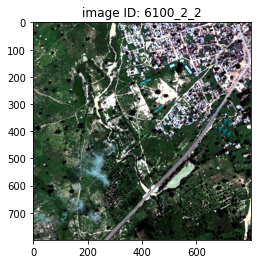

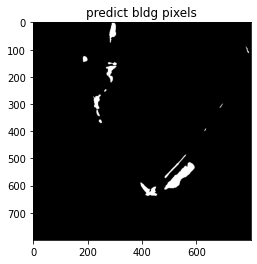

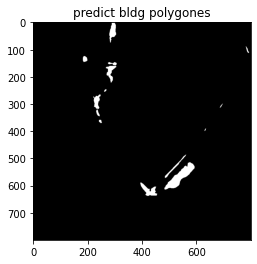

In [ ]:
check_predict(id='6100_2_2', mskn=6)

## Improvemnt

- Use large sizes of Image i.e.-1600
- Use hyperperameter tuning for U-Net.
- To improve, run the same U-Net model for several classes individually (change the output to only include one class). I used additional single models for buildings, structures, tracks and trees, the other predictions performed better from the 10 class model.

Thanks to visoft, n01z3, Sergey Mushinskiy, Konstantin Lopuhin for the great scripts and discussions.

In [22]:
import pytest 

class unitetest:
    def test_get_xmax_ymin(self):
        x,y = get_xmax_ymin(GS=grid_sizes, imageId="6010_0_0")
        nx,ny = 0.009188,-0.009040
        assert abs(x-nx) <=1e-6 ,"get_xmax_ymin test failed"
        assert abs(y-ny) <=1e-6 ,"get_xmax_ymin test failed"
        x,y = get_xmax_ymin(GS=grid_sizes, imageId="6010_0_1")
        nx,ny = 0.009169,-0.009042
        assert abs(x-nx) <=1e-6 ,"get_xmax_ymin test failed"
        assert abs(y-ny) <=1e-6 ,"get_xmax_ymin test failed"
        x,y = get_xmax_ymin(GS=grid_sizes, imageId="6060_1_3")
        nx,ny = 0.009158,-0.009043
        assert abs(x-nx) <=1e-6 ,"get_xmax_ymin test failed"
        assert abs(y-ny) <=1e-6 ,"get_xmax_ymin test failed"

    def test_get_polygon_list(self):
        x = get_polygon_list(wkt_list=tr_wkt, imageId="6040_2_2", cType=2)
        y = 0
        assert len(x) == y, "test_get_polygon_list failed"
        x = get_polygon_list(wkt_list=tr_wkt, imageId="6040_2_2", cType=5)
        y = 3879
        assert len(x) == y, "test_get_polygon_list failed"
        x = get_polygon_list(wkt_list=tr_wkt, imageId="", cType=2)
        y = None
        assert x == y, "test_get_polygon_list failed"
        x = get_polygon_list(wkt_list=tr_wkt, imageId="6040_2_2", cType=200)
        y = None
        assert x == y, "test_get_polygon_list failed"
        x = get_polygon_list(wkt_list=tr_wkt, imageId="6040_2_2", cType=-8)
        y = None
        assert x == y, "test_get_polygon_list failed"
        x = get_polygon_list(wkt_list=tr_wkt, imageId="6040_2_2", cType=1.87)
        y = None
        assert x == y, "test_get_polygon_list failed"
        x = get_polygon_list(wkt_list=tr_wkt, imageId="6160_2_1", cType=4)
        y = 8
        assert len(x) == y, "test_get_polygon_list failed"

    def test_plot_mask_from_contours(self):
        x = plot_mask_from_contours(img_size=(10,10), contours=None)
        assert x.all() == 0, "plot_mask_from_contours test failed"
        x = plot_mask_from_contours(img_size=(-2,10), contours=None)
        assert x == None, "plot_mask_from_contours test failed"
        x = plot_mask_from_contours(img_size=(1,0), contours=None)
        assert x == None, "plot_mask_from_contours test failed"
        x = plot_mask_from_contours(img_size=None, contours=None)
        assert x == None, "plot_mask_from_contours test failed"

    def test_get_and_convert_contours(self):
        x = get_and_convert_contours(polygonList=None, img_size=(-2,10), xy_coods=None) 
        assert x == None, "get_and_convert_contours test failed"
        xy = get_xmax_ymin(GS=grid_sizes, imageId="6040_2_2")
        x = get_and_convert_contours(polygonList=None, img_size=(-2,10), xy_coods=xy) 
        assert x == None, "get_and_convert_contours test failed"
        polygons = get_polygon_list(wkt_list=tr_wkt, imageId="6040_2_2", cType=5)
        x = get_and_convert_contours(polygonList=polygons, img_size=(-2,10), xy_coods=xy) 
        assert x == None, "get_and_convert_contours test failed"
        x = get_and_convert_contours(polygonList=polygons, img_size=(800,800), xy_coods=xy)
        assert x != None, "get_and_convert_contours test failed"


    def test_all_image(self):
        x = all_image(image_id=None, dims=None, size=800)
        assert x == None, "all_image test failed"
        x = all_image(image_id="6040_2_2", dims=None, size=-300)
        assert x == None, "all_image test failed"
        x = all_image(image_id="6040_2_2", dims=chosen_bands, size=0)
        assert x == None, "all_image test failed"
        x = all_image(image_id="6040_2_2", dims=3, size=800)
        assert x.any , "all_image test failed"

    def test_mask_to_polygons(self):
        size=100
        mask = np.zeros(im_size, np.uint8)

        x = mask_to_polygons(mask, epsilon=1, min_area=10)
        assert x == None, "mask_to_polygons test failed"
        x = mask_to_polygons(mask, epsilon=1, min_area=10)
        assert x == None, "mask_to_polygons test failed"
        x = mask_to_polygons(mask, epsilon=1, min_area=10)
        assert x == None, "mask_to_polygons test failed"
        x = mask_to_polygons(mask, epsilon=1, min_area=10)
        assert x.any , "mask_to_polygons test failed"








test=unitetest()
test.test_get_xmax_ymin()
print("get_xmax_ymin test passed")
test.test_get_polygon_list()
print("get_polygon_list test passed")
test.test_plot_mask_from_contours()
print("plot_mask_from_contours test passed")
test.test_get_and_convert_contours()
print("get_and_convert_contours test passed")
test.test_all_image()
print("all_image test passed")
test.test_mask_to_polygons()
print("mask_to_polygons test passed")

get_xmax_ymin test passed
get_polygon_list test passed
plot_mask_from_contours test passed
get_and_convert_contours test passed
all_image test passed
